In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv
/kaggle/input/ml-competition-2024-for-ukrainians/train.csv
/kaggle/input/ml-competition-2024-for-ukrainians/test.csv
/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv
/kaggle/input/test-kaglle/kaggle.json


# VAE definition

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
# Define Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define Encoder layer
class Encoder(layers.Layer):
    """Maps inputs to a triplet (z_mean, z_log_var, z)."""
    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

# Define Decoder layer
class Decoder(layers.Layer):
    """Converts z, the encoded vector, back into a readable format."""
    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

# Define Variational AutoEncoder model
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32, name="autoencoder", **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

2024-06-26 11:42:33.087059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 11:42:33.087177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 11:42:33.218642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
USE_VAE = False
USE_ORIGINAL_DATA = False

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
train_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/train.csv')
additional_data = pd.read_csv('/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv')
test_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/test.csv')
test_ids = test_data['id'] if 'id' in test_data.columns else test_data.index
if USE_ORIGINAL_DATA:
    train_data = pd.concat([train_data, additional_data], axis=0)

# EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

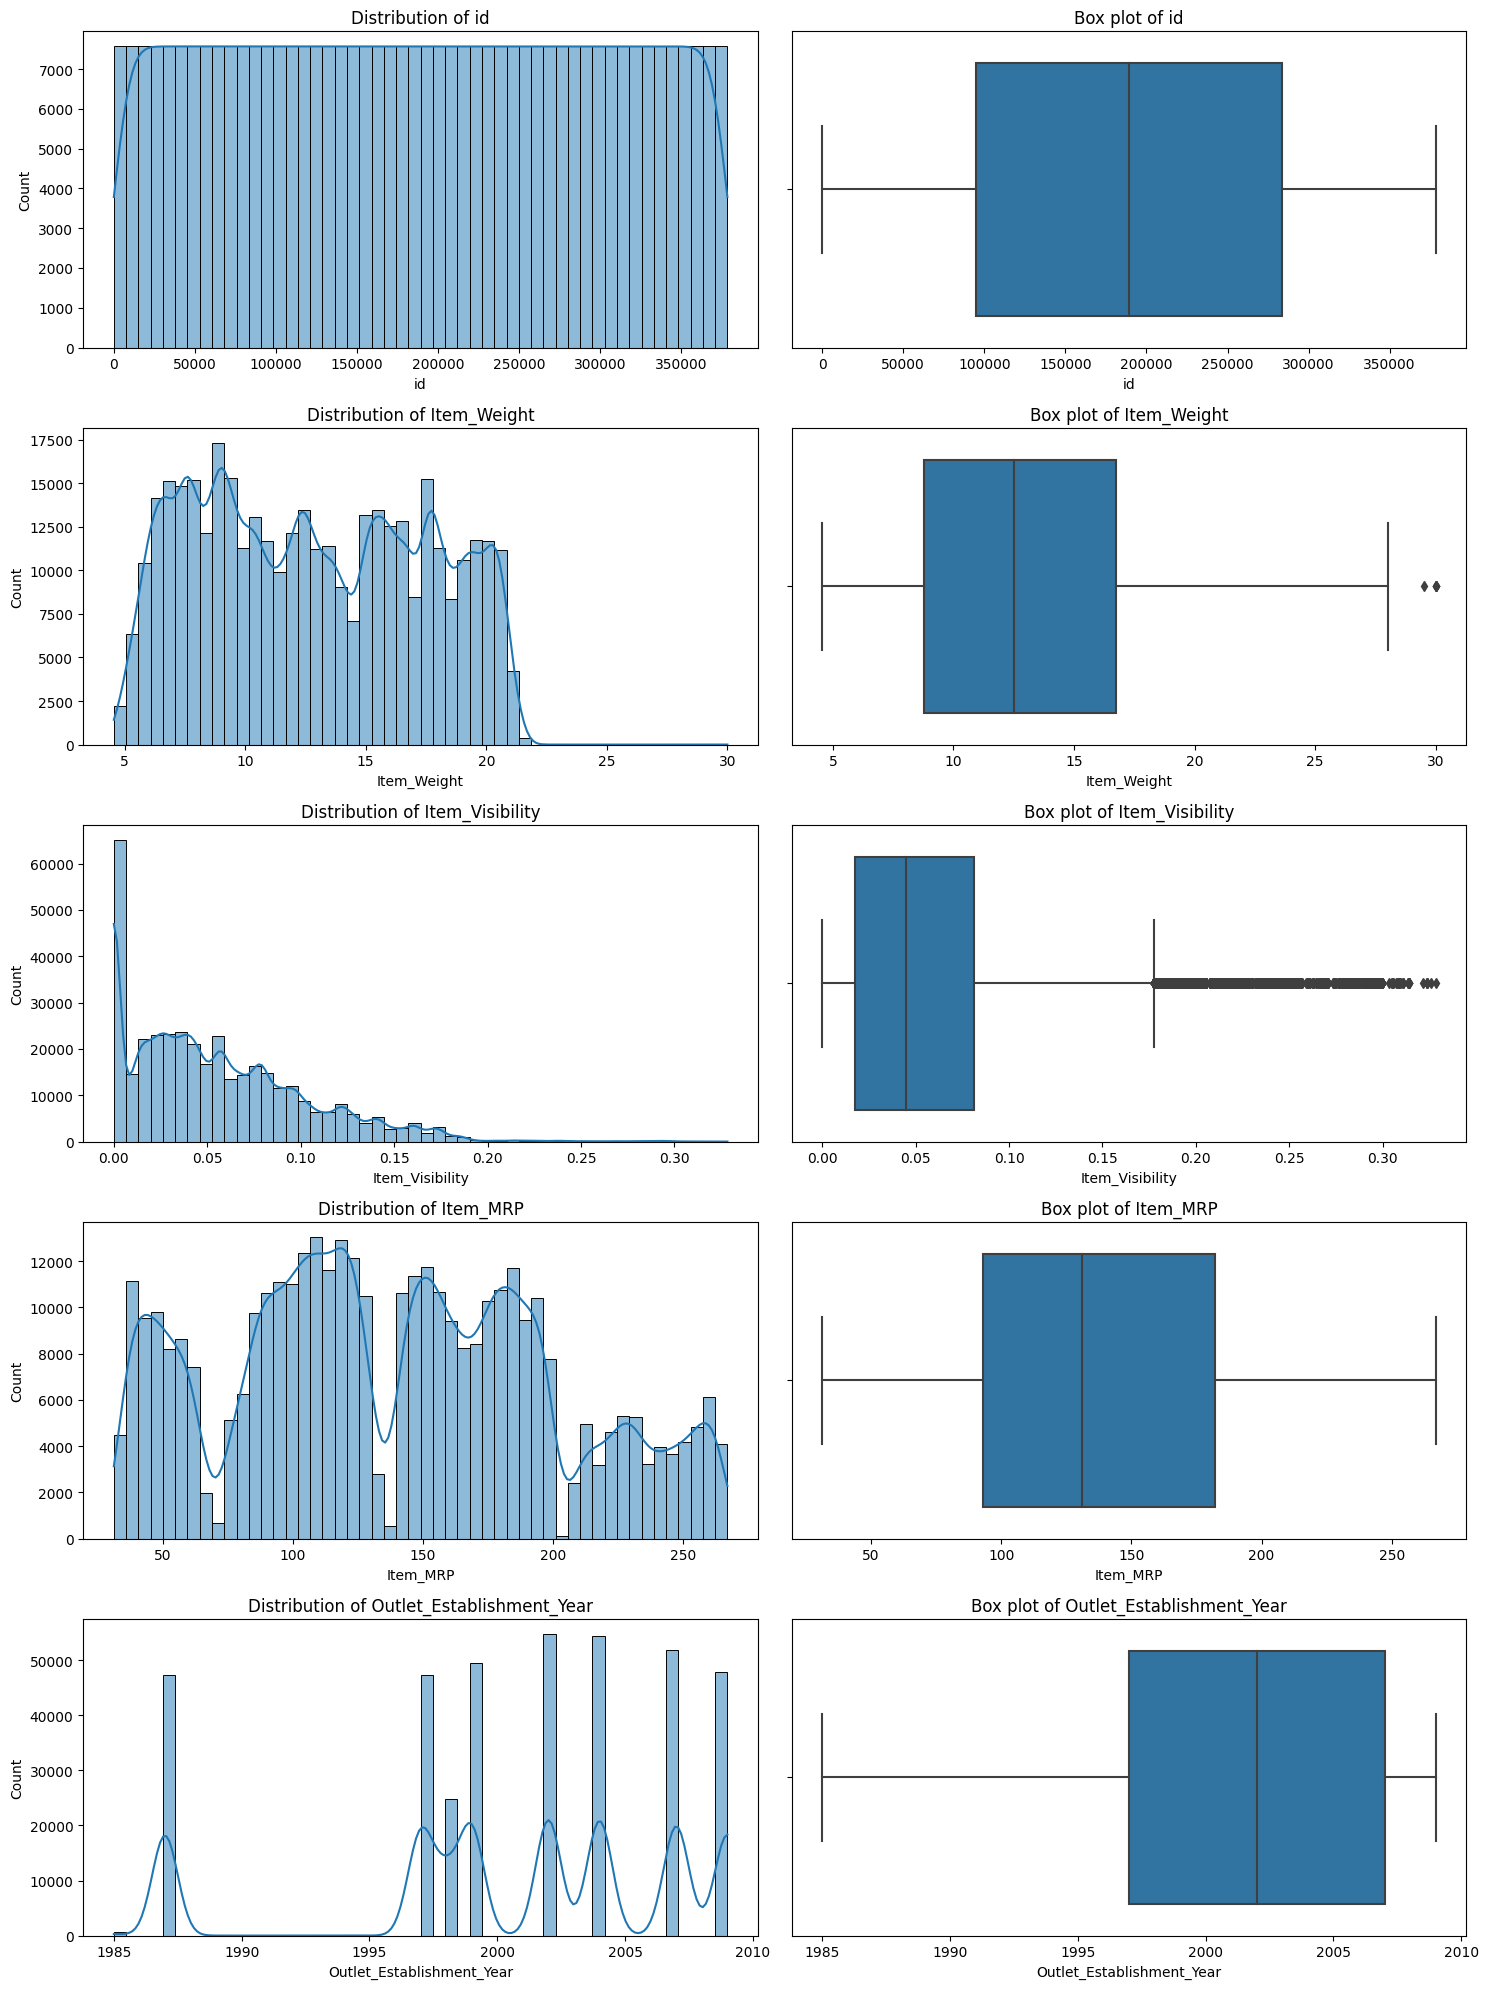

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric features
numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove the target variable from the list
numeric_features.remove('Item_Outlet_Sales')

# Plot histograms and box plots for each numeric feature
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 2, 2*i+1)
    sns.histplot(train_data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    
    plt.subplot(len(numeric_features), 2, 2*i+2)
    sns.boxplot(x=train_data[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()


In [6]:
# Calculate skewness for each numeric feature
skewness = train_data[numeric_features].skew().sort_values(ascending=False)
print("Skewness of numeric features:")
print(skewness)

Skewness of numeric features:
Item_Visibility              9.970457e-01
Item_MRP                     1.867041e-01
Item_Weight                  1.083624e-01
id                           3.819076e-16
Outlet_Establishment_Year   -7.985328e-01
dtype: float64


In [7]:
# Calculate skewness for numerical columns
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
train_skewness = train_data[numerical_columns].skew()
test_skewness = test_data[numerical_columns].skew()

# Define a threshold for skewness; typically values > 0.5 or < -0.5 are considered skewed
skewed_columns_train = train_skewness[abs(train_skewness) > 0.5].index
skewed_columns_test = test_skewness[abs(test_skewness) > 0.5].index

# Apply transformations to reduce skewness in training data
for col in skewed_columns_train:
    if any(train_data[col] <= 0):  # Check if the column contains non-positive values
        # Apply a log transformation to columns with only positive values
        train_data[col] = np.log1p(train_data[col])
    else:
        # Apply Box-Cox transformation to handle non-positive values
        train_data[col], _ = boxcox(train_data[col] + 1)  # Add 1 to avoid zero values

# Apply transformations to reduce skewness in test data
for col in skewed_columns_test:
    if any(test_data[col] <= 0):  # Check if the column contains non-positive values
        # Apply a log transformation to columns with only positive values
        test_data[col] = np.log1p(test_data[col])
    else:
        # Apply Box-Cox transformation to handle non-positive values
        test_data[col], _ = boxcox(test_data[col] + 1)  # Add 1 to avoid zero values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


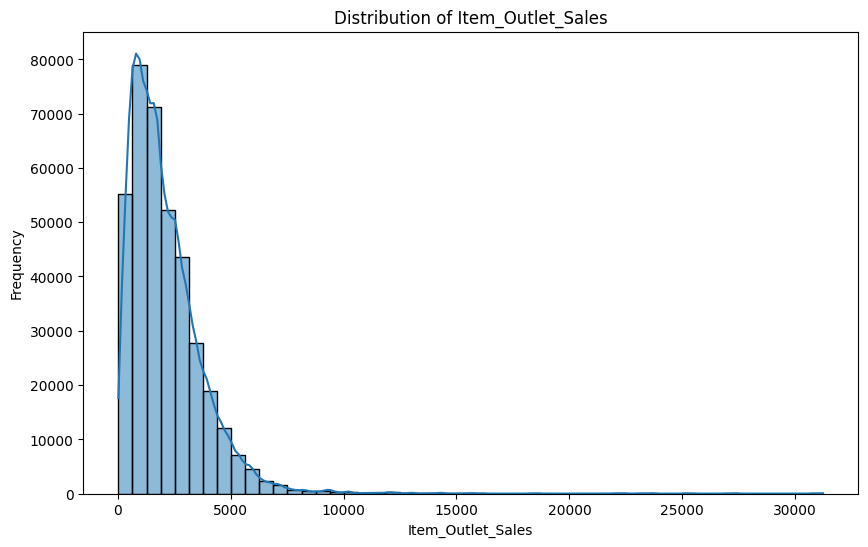

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Frequency')
plt.show()

# Feature Engineering

In [9]:
# Feature Engineering
#train_data['Item_Visibility_MRP_Ratio'] = train_data['Item_Visibility'] / train_data['Item_MRP']
#test_data['Item_Visibility_MRP_Ratio'] = test_data['Item_Visibility'] / test_data['Item_MRP']
#train_data['Item_Weight_Visibility_Ratio'] = train_data['Item_Weight'] / train_data['Item_Visibility']
#test_data['Item_Weight_Visibility_Ratio'] = test_data['Item_Weight'] / test_data['Item_Visibility']
#train_data['Item_Visibility_Squared'] = train_data['Item_Visibility'] ** 2
#test_data['Item_Visibility_Squared'] = test_data['Item_Visibility'] ** 2

#Create a new feature for Outlet Age
#train_data['Outlet_Age'] = 2024 - train_data['Outlet_Establishment_Year']
#test_data['Outlet_Age'] = 2024 - test_data['Outlet_Establishment_Year']

# Clean the Item_Fat_Content column
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')

# Combine similar Item_Type categories
train_data['Item_Type_Combined'] = train_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')
test_data['Item_Type_Combined'] = test_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')

# Data preparation

In [10]:
# Encoding categorical variables
categorical_columns = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Combined']
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Aligning test data columns with train data columns
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [11]:
# Replace zero visibility values with the mean visibility
mean_visibility = train_data['Item_Visibility'].mean()
train_data['Item_Visibility'] = train_data['Item_Visibility'].replace(0, mean_visibility)
test_data['Item_Visibility'] = test_data['Item_Visibility'].replace(0, mean_visibility)

In [12]:
# Remove outliers in Item_Outlet_Sales using IQR method
Q1_sales = train_data['Item_Outlet_Sales'].quantile(0.25)
Q3_sales = train_data['Item_Outlet_Sales'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
train_data = train_data[~((train_data['Item_Outlet_Sales'] < (Q1_sales - 1.5 * IQR_sales)) | 
                              (train_data['Item_Outlet_Sales'] > (Q3_sales + 1.5 * IQR_sales)))]

# Remove outliers in Item_Weight using IQR method
Q1_weight = train_data['Item_Weight'].quantile(0.25)
Q3_weight = train_data['Item_Weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
train_data = train_data[~((train_data['Item_Weight'] < (Q1_weight - 1.5 * IQR_weight)) | 
                              (train_data['Item_Weight'] > (Q3_weight + 1.5 * IQR_weight)))]

In [13]:
# Checking for missing values in train and test data
print(train_data.isnull().sum())
print(test_data.isnull().sum())
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Handle missing values
train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)
# Fill NaNs by column means only if they have NaNs
for col in train_data.columns:
    if train_data[col].isna().any():
        train_data[col].fillna(train_data[col].mean(), inplace=True)
for col in test_data.columns:
    if test_data[col].isna().any():
        test_data[col].fillna(test_data[col].mean(), inplace=True)

id                                   0
Item_Identifier                      0
Item_Weight                          0
Item_Visibility                      0
Item_Type                            0
Item_MRP                             0
Outlet_Identifier                    0
Outlet_Establishment_Year            0
Item_Outlet_Sales                    0
Item_Fat_Content_Low Fat             0
Item_Fat_Content_Regular             0
Outlet_Size_High                     0
Outlet_Size_Medium                   0
Outlet_Size_Small                    0
Outlet_Location_Type_Tier 1          0
Outlet_Location_Type_Tier 2          0
Outlet_Location_Type_Tier 3          0
Outlet_Type_Grocery Store            0
Outlet_Type_Supermarket Type1        0
Outlet_Type_Supermarket Type2        0
Outlet_Type_Supermarket Type3        0
Item_Type_Combined_Consumable        0
Item_Type_Combined_Non-Consumable    0
dtype: int64
id                                   0
Item_Identifier                      0
Item_Weight 

/tmp/ipykernel_34/2705562751.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
/tmp/ipykernel_34/2705562751.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [14]:
# Dropping the target variable from test data
test_data.drop(['Item_Outlet_Sales'], axis=1, inplace=True)
# Apply log transformation to the target variable
train_data['Log_Item_Outlet_Sales'] = np.log1p(train_data['Item_Outlet_Sales'])
# Drop 'Item_Identifier' and 'Item_Type'
train_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)
test_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)
# Use the transformed target variable for training
y = train_data['Log_Item_Outlet_Sales']
X = train_data.drop(['Item_Outlet_Sales', 'Log_Item_Outlet_Sales'], axis=1)

In [15]:
# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_data = scaler.transform(test_data)

In [16]:
# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# VAE training

In [17]:
if USE_VAE:
    # Initialize and compile VAE
    vae = VariationalAutoEncoder(X_train.shape[1], intermediate_dim=64, latent_dim=32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    vae.compile(optimizer=optimizer)

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Train the VAE
    history = vae.fit(X_train, X_train, 
                      validation_data=(X_valid, X_valid), 
                      epochs=10, 
                      batch_size=64, 
                      validation_freq=2,
                      callbacks=[early_stopping])

# Additional samples, adding to the data

In [18]:
if USE_VAE:
    # Generate synthetic data
    # Number of synthetic samples to generate
    num_synthetic_samples = 800000  # You can adjust this value as needed

    # Generate latent space samples
    latent_dim = 32  # Must match the latent_dim used in the VAE
    latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim))

    # Generate synthetic X data using the decoder
    X_synthetic = vae.decoder(latent_samples).numpy()

    # Bootstrap Y values
    y_bootstrap = np.random.choice(y_train, size=num_synthetic_samples, replace=True)

    # Combine original and synthetic data
    X_combined = np.vstack([X_train, X_synthetic])
    y_combined = np.hstack([y_train, y_bootstrap])

    # Split the combined data into training and validation sets
    X_train_augmented, X_valid_augmented, y_train_augmented, y_valid_augmented = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
else:
    X_train_augmented = X_train
    X_valid_augmented = X_valid
    y_train_augmented = y_train
    y_valid_augmented = y_valid

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


I0000 00:00:1719402194.725273     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9192/9192 - 42s - 5ms/step - loss: 0.7104 - val_loss: 0.1075
Epoch 2/20
9192/9192 - 19s - 2ms/step - loss: 0.1367 - val_loss: 0.0991
Epoch 3/20
9192/9192 - 20s - 2ms/step - loss: 0.1081 - val_loss: 0.0968
Epoch 4/20
9192/9192 - 19s - 2ms/step - loss: 0.1016 - val_loss: 0.0972
Epoch 5/20
9192/9192 - 20s - 2ms/step - loss: 0.1006 - val_loss: 0.0971
Epoch 6/20
9192/9192 - 20s - 2ms/step - loss: 0.0999 - val_loss: 0.0958
Epoch 7/20
9192/9192 - 20s - 2ms/step - loss: 0.0995 - val_loss: 0.0943
Epoch 8/20
9192/9192 - 20s - 2ms/step - loss: 0.0993 - val_loss: 0.0956
Epoch 9/20
9192/9192 - 20s - 2ms/step - loss: 0.0990 - val_loss: 0.0956
Epoch 10/20
9192/9192 - 20s - 2ms/step - loss: 0.0987 - val_loss: 0.0997
Epoch 11/20
9192/9192 - 20s - 2ms/step - loss: 0.0985 - val_loss: 0.0960
Epoch 12/20
9192/9192 - 20s - 2ms/step - loss: 0.0983 - val_loss: 0.0937
Epoch 13/20
9192/9192 - 19s - 2ms/step - loss: 0.0981 - val_loss: 0.0935
Epoch 14/20
9192/9192 - 20s - 2ms/step - loss: 0.0979 - val_loss: 0.096

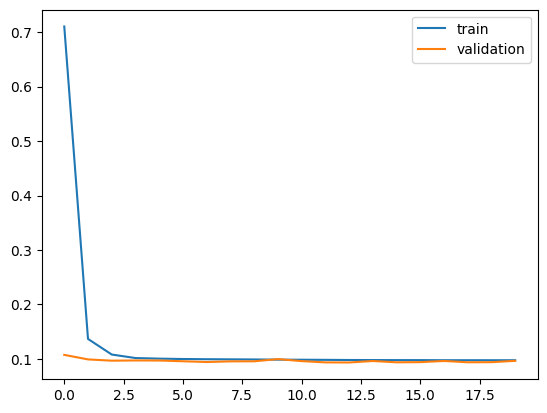

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

def rmsle(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# Or use a wrapper around the existing MSLE loss
def rmsle_from_msle(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))
# Build the neural network model
# Build the neural network model with LeakyReLU and Exponential Decay for learning rate
def create_model():
    model = Sequential([
        Dense(256, input_shape=(X_train_augmented.shape[1],), kernel_regularizer=l2(0.05)),  # Increased L2 regularization
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),  # Increased dropout

        Dense(128, kernel_regularizer=l2(0.05)),  # Increased L2 regularization
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),  # Increased dropout

        Dense(64, kernel_regularizer=l2(0.05)),  # Increased L2 regularization
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),  # Increased dropout

        Dense(32, kernel_regularizer=l2(0.05)),  # Increased L2 regularization
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),  # Increased dropout

        Dense(16, kernel_regularizer=l2(0.05)),  # Increased L2 regularization
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),  # Increased dropout

        Dense(1, activation='linear')
    ])

    initial_learning_rate = 0.0005  # Reduced learning rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=rmsle_from_msle)
    return model

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the final model on the entire training data
final_model = create_model()
final_history = final_model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_valid_augmented, y_valid_augmented),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Plot training history of the final model
import matplotlib.pyplot as plt

plt.plot(final_history.history['loss'], label='train')
plt.plot(final_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [20]:
# Make predictions on the test set
test_preds = final_model.predict(test_data)
test_preds = np.expm1(test_preds)
# Ensure no negative values in test predictions
test_preds = np.maximum(0, test_preds)
test_preds = np.nan_to_num(test_preds)
# Preparing the submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Item_Outlet_Sales': test_preds.flatten()
})
# Ensure no null values in submission
for column in submission.columns:
    if submission[column].dtype == np.number:
        mean_value = submission[column].mean()
        submission[column].fillna(mean_value, inplace=True)
submission.to_csv('submission_nn.csv', index=False)


7884/7884 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


/tmp/ipykernel_34/3542575177.py:14: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if submission[column].dtype == np.number:


In [22]:
import json
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Assuming you've uploaded 'kaggle.json' to the notebook's environment

# Load the 'kaggle.json' file
with open('/kaggle/input/test-kaglle/kaggle.json') as f:
    kaggle_creds = json.load(f)

# Ensure the directory exists
os.makedirs('/root/.kaggle/', exist_ok=True)

# Write the credentials to the correct location
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

# Authenticate the API
api = KaggleApi()
api.authenticate()

!kaggle competitions submit -c 'ml-competition-2024-for-ukrainians' -f '/kaggle/working/submission_nn.csv' -m "NN submission with full dataset and data preparation"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


100%|██████████████████████████████████████| 4.03M/4.03M [00:00<00:00, 6.02MB/s]
Successfully submitted to Kaggle Competition 2024 for Ukrainians